In [15]:
# Importing dependencies
import pandas as pd
from pathlib import Path
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [16]:
# Reading in the data
file_path = Path('Resources/cleaned_data.csv')
df = pd.read_csv(file_path)
df.head()

,sex,age,education,smokingStatus,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose,CHDRisk,MAP
0,1.0,39,4,0.0,0,0,0,0,0,195,26.97,80,77,0,82.000000
1,0.0,46,2,0.0,0,0,0,0,0,250,28.73,95,76,0,94.333333
2,1.0,48,1,1.0,20,0,0,0,0,245,25.34,75,70,0,95.833333
3,0.0,61,3,1.0,30,0,0,1,0,225,28.58,65,103,1,113.333333
4,0.0,46,3,1.0,23,0,0,0,0,285,23.10,85,85,0,99.333333


In [17]:
# Separating target variables and features
y = df['CHDRisk']
X = df.drop(columns='CHDRisk')

In [18]:
y.value_counts()

CHDRisk
0    3084
1     553
Name: count, dtype: int64

In [19]:
# Using RandomOverSampler to balance the target variable conditions
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(df.drop('CHDRisk', axis=1), df['CHDRisk'])

y = y_resampled
X = X_resampled

In [20]:
y.value_counts()

CHDRisk
0    3084
1    3084
Name: count, dtype: int64

In [21]:
# Splitting the data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=1, stratify=y)

In [22]:
X_train.shape

(4626, 14)

In [23]:
y_train.shape

(4626,)

In [24]:
# Scaling the feature variables
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
# Instantiating the model
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [26]:
# Training the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [27]:
# Making predictions with the testing data
predictions = rf_model.predict(X_test_scaled)

In [28]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy and recall scores
acc_score = accuracy_score(y_test, predictions)

In [29]:
# Printing the results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,708,63
Actual 1,9,762


Accuracy Score : 0.953307392996109
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       771
           1       0.92      0.99      0.95       771

    accuracy                           0.95      1542
   macro avg       0.96      0.95      0.95      1542
weighted avg       0.96      0.95      0.95      1542



In [30]:
# Calculating feature importances and listing by importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.16296306342827346, 'age'),
 (0.1602459499389317, 'MAP'),
 (0.1371175901973798, 'BMI'),
 (0.12781640944367148, 'totChol'),
 (0.12760479453071416, 'glucose'),
 (0.10558339501348721, 'heartRate'),
 (0.05284090868710578, 'cigsPerDay'),
 (0.04012713207176668, 'education'),
 (0.030734173756760096, 'prevalentHyp'),
 (0.026475360702545272, 'sex'),
 (0.013362915842121821, 'smokingStatus'),
 (0.006845277695520114, 'BPMeds'),
 (0.006532289131593016, 'diabetes'),
 (0.0017507395601293568, 'prevalentStroke')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

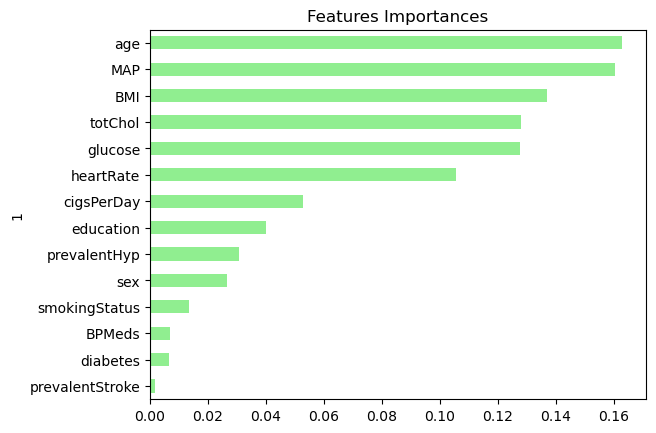

In [31]:
# Visualizing the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

Using k-fold cross-validation to ensure model is not overfitting

In [32]:
# Setting up k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

In [33]:
X_resampled_scaled = scaler.fit_transform(X_resampled)
#Perform cross-validation
cv_results = cross_val_score(rf_model, X_resampled_scaled, y_resampled, cv=kf, scoring='accuracy')

# Print cross-validation results
print(f'Cross-validation results (accuracy): {cv_results}')
print(f'Mean cross-validation accuracy: {cv_results.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_results.std()}')

Cross-validation results (accuracy): [0.96758509 0.96353323 0.97082658 0.96836983 0.98053528]
Mean cross-validation accuracy: 0.9701700008281182
Standard deviation of cross-validation accuracy: 0.005689275507304944


In [35]:
# Saving the model
import pickle

# Example model object, replace with your actual model
# rf_model = ...

# Specify the file name
pickle_file = "rf_model.pkl"

# Open the file in binary write mode and save the model
with open(pickle_file, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model saved to {pickle_file}")

Model saved to rf_model.pkl
